In [1]:
import path_setup
import scipy.io as spio
import mat73
import scipy.io.matlab as spiomat
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
import matplotlib
from sklearn.model_selection import train_test_split
from blind_localization.data.datasets import *
from blind_localization.models.contrastive import *
from blind_localization.models.contrastive_pipeline import *
from blind_localization.models.decoder import *
from blind_localization.visualize import *
from tqdm import tqdm
import wandb
import pickle
from script.utils import save_if_better
from sklearn.linear_model import LogisticRegression

/home/th3129/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os

parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
os.chdir(parent_dir)

### Helper Function

In [4]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    try:
        data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
        return _check_keys(data)
    except:
        return mat73.loadmat(filename)

In [5]:
class DotDict(dict):
    # def __getattr__(self, name):
    #     return self[name]
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    def __init__(self, dct):
        for key, value in dct.items():
            if hasattr(value, 'keys'):
                value = DotDict(value)
            self[key] = value
    
    def __repr__(self) -> str:
        return str(list(self.keys()))
    
    def __getstate__(self):
        # Return what you want to pickle
        return self.__dict__

    def __setstate__(self, state):
        # Restore state from the unpickled state
        self.__dict__.update(state)
    

def loadmat_full(filename,structname=None):
    if structname is None:
        mat = loadmat(filename)
    else:
        mat = loadmat(filename)[structname]
    mat = DotDict(mat)
    return mat

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        # if isinstance(dict[key], spiomat.mio5_params.mat_struct):
        if isinstance(dict[key], scipy.io.matlab.mat_struct):
            dict[key] = _todict(dict[key])
        
        elif isinstance(dict[key], np.ndarray):
            
            dict_key_res = np.zeros_like(dict[key])
            # with np.nditer([dict[key],dict_key_res],op_flags=[['readonly'], ['readwrite']]) as it:
            for ind,x in np.ndenumerate(dict_key_res): 
                orig_val = dict[key][ind]
                
                if isinstance(orig_val,scipy.io.matlab.mat_struct):
                    dict_key_res[ind] = _todict(orig_val)
                else:
                    dict_key_res[ind] = orig_val

            dict[key] = dict_key_res
        
    return dict

In [6]:
def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        # if isinstance(elem, spiomat.mio5_params.mat_struct):
        if isinstance(elem, scipy.io.matlab.mat_struct):
            dict[strg] = _todict(elem)
        elif isinstance(elem,np.ndarray) and len(elem) >= 1: # used for the multi maze case; then there might be a cell array of struct that is not correctly unwrapped
            # if isinstance(elem[0], spiomat.mio5_params.mat_struct):
            if isinstance(elem, scipy.io.matlab.mat_struct):
                dict[strg] = np.array([_todict(e) for e in elem],dtype=object)
            else:
                dict[strg] = elem
        else:
            dict[strg] = elem
    return dict

### 1. Load Raw Waveform

In [7]:
sessions=['AD_HF01_Session1h', 'AD_HF02_230706_Session2', 'AD_HF02_230722_Session4', 'AD_HF03_230725_Session1', 'AD_HF03_230726_Session2', 'NN_syn_20230601', 'NN_syn_20230607']
session_names = ['AD_HF01_1', 'AD_HF02_2', 'AD_HF02_4', 'AD_HF03_1', 'AD_HF03_2', 'NN_syn_01', 'NN_syn_02']
waveforms_all = []
class_labels_selected_all = []  # class_labels of channels with maxWaveform assigned to it
class_labels_all = []
maxWaveformCh_all = []
channel_channel_maps = []
spike_times_all = []

for i, session in enumerate(sessions):
    file_path = f"/scratch/th3129/shared/Neuronexus_dataset/{session}/{session}.spikes.cellinfo.mat"
    mat = loadmat_full(file_path, structname='spikes')

    # find channel_channel_map to fix channel
    source_file = load_session_data("script/Neuronexus_preprocessing/file_path_hpc.json", session_names[i])
    public_file = load_session_data("script/Neuronexus_preprocessing/file_path_hpc.json", "public")
    
    raw_signal, df, skipped_channels = load_data(source_file["raw_signal_path"], public_file["label_path"], source_file["xml_path"], sheet_name=source_file["sheet_name"],
                                                 sample_rate=20000, T=30)
    channel_region_map, skipped_channels, channel_channel_map = process_labels(df, public_file["mapping_path"], skipped_channels)
    raw_signal = process_signals(raw_signal, channel_channel_map)

    # load raw signal and raw waveform
    raw_signal, class_labels, swr_timestamp = load_signal_labels(session_names[i])
    
    raw_waveforms = np.vstack(mat['rawWaveform'])
    maxWaveformCh = np.array([channel_channel_map[maxCh] for maxCh in mat['maxWaveformCh']])
    class_label_selected = class_labels[maxWaveformCh]

    waveforms_all.append(raw_waveforms[class_label_selected != 5])
    class_labels_selected_all.append(class_label_selected[class_label_selected != 5])
    maxWaveformCh_all.append(maxWaveformCh[class_label_selected != 5])
    spike_times_all.append(mat['times'][class_label_selected != 5])
    class_labels_all.append(class_labels)
    channel_channel_maps.append(channel_channel_map)

100%|██████████| 1024/1024 [00:02<00:00, 495.20it/s]


In [8]:
color_names = ["red", "orange", "green", "blue", "magenta", "black"]
colors_all = [[color_names[c] for c in class_labels] for class_labels in class_labels_selected_all]

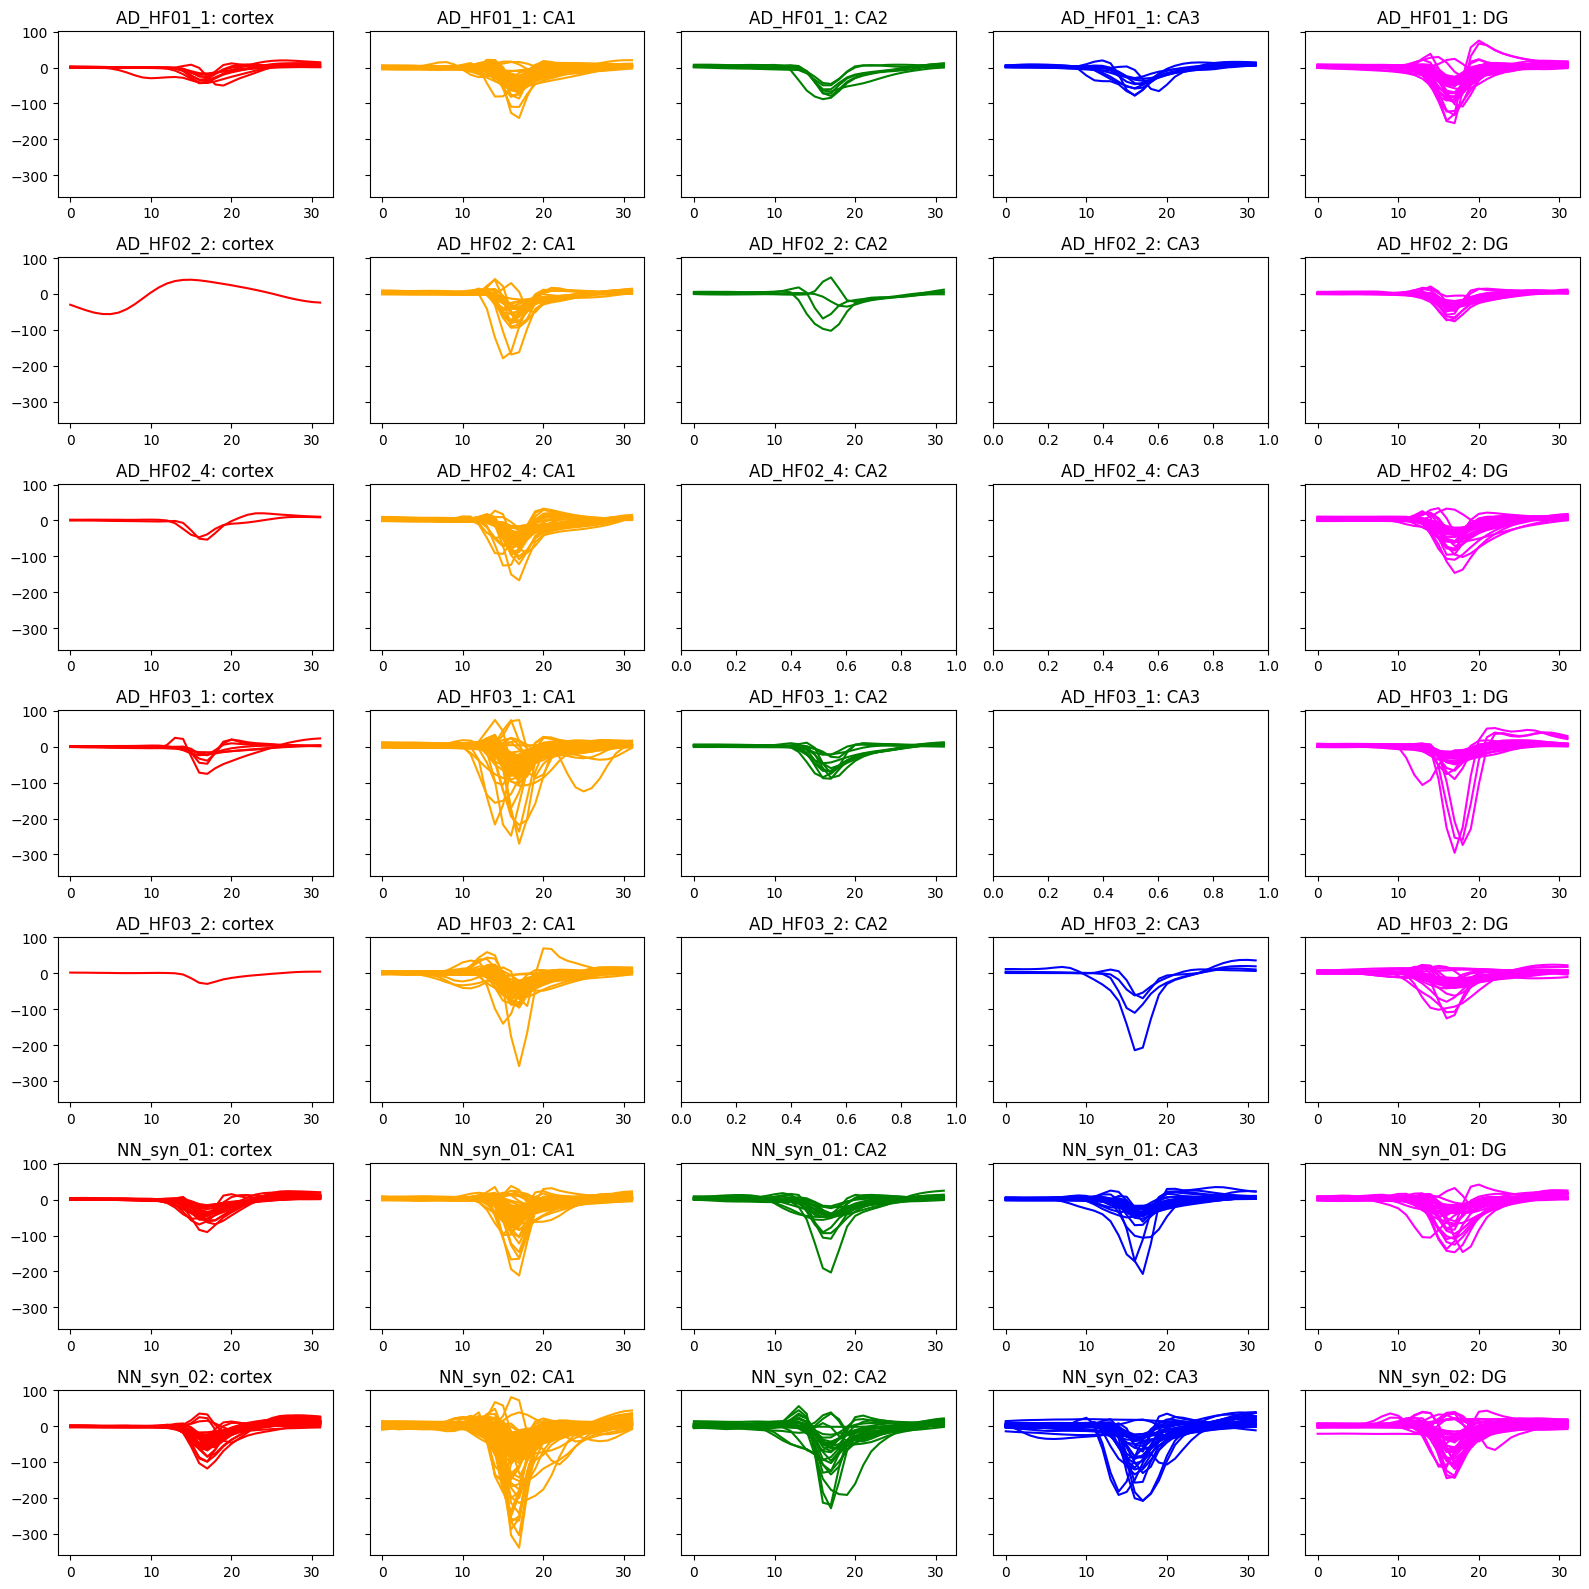

In [9]:
# normalize by the channels in std
fig, axes = plt.subplots(len(sessions), len(color_names)-1, figsize=(16, 16), sharey=True)
brain_regions = ['cortex', 'CA1', 'CA2', 'CA3', 'DG']

for s in range(len(session_names)):
    for color_idx, color in enumerate(color_names[:-1]):
        raw_waveforms = waveforms_all[s]
        colors = colors_all[s]
        
        for i, (wav, wav_color) in enumerate(zip(raw_waveforms, colors)):
            if wav_color == color:
                axes[s][color_idx].plot(wav, c=color)
    
        axes[s][color_idx].set_title(f"{session_names[s]}: {brain_regions[color_idx]}")

plt.tight_layout()
plt.show()

In [10]:
# for each spike time, extract the LFP signal (and spike waveforms) for that trial
# spike_times = mat['times']
# t_min, t_max = 2160, 2340
# selected_timestamp = [s[(s > t_min) & (s < t_max)] for s in spike_times]

In [11]:
sessions=['AD_HF01_Session1h', 'AD_HF02_230706_Session2', 'AD_HF02_230722_Session4', 'AD_HF03_230725_Session1', 'AD_HF03_230726_Session2', 'NN_syn_20230601', 'NN_syn_20230607']
channel_waveforms_all = []
goodChannels_all = []

for i, session in enumerate(sessions):
    file_path = f"/scratch/th3129/region_decoding/data/Neuronexus/waveforms/{sessions[i]}_waveforms.mat"
    mat = loadmat_full(file_path, structname='spikesNew')
    waveform_dist = np.array(mat['avgWaveform'])

    file_path = f"/scratch/th3129/shared/Neuronexus_dataset/{session}/{session}.session.mat"
    mat = loadmat_full(file_path, structname='session')
    badChannels = mat['channelTags']['Bad']['channels']
    badChannels = badChannels - 1
    channel_channel_map = channel_channel_maps[i]
    badChannels = np.array([channel_channel_map[int(ch)] for ch in badChannels])
        
    goodChannels = np.setdiff1d(np.arange(1024), badChannels)
    
    channel_waveforms_all.append(waveform_dist)
    goodChannels_all.append(goodChannels)

In [12]:
goodChannels

array([   0,    1,    2, ..., 1021, 1022, 1023])

In [13]:
def visualize_channel_waveform(all_waveforms, all_channels, maxWaveformChannels=None, rows=128, cols=8, scale=100, top_n=5, n_neurons=5, percentile=80, channel_samples=4):
    fig, ax = plt.subplots()

    for n in range(n_neurons):
        waveforms = all_waveforms[n]
        channels = all_channels[::channel_samples]
        
        xs = channels // rows * scale
        ys = np.mod(channels, rows) 
    
        amplitudes = [np.max(np.abs(waveform)) for waveform in waveforms]
        top_n_amplitudes = sorted(amplitudes, reverse=True)[:top_n]
        scaling_factor = np.mean(top_n_amplitudes)
        amp_threshold = np.percentile(amplitudes, percentile)
        
        scaled_waveforms = [waveform / scaling_factor for waveform in waveforms]
        norm_amplitudes = (amplitudes - np.min(amplitudes)) / (np.max(amplitudes) - np.min(amplitudes) + 1e-8)
        
        cmap = cm.YlOrBr
        colors = cmap(norm_amplitudes)
        
        ax.scatter(xs, ys, color='gray')
        
        for i, (x, y) in enumerate(zip(xs, ys)):            
            offset_waveform = scaled_waveforms[i] *5 + y
            if amplitudes[i] > amp_threshold:
                ax.plot(np.arange(len(waveforms[i])) + x, offset_waveform, color=colors[i])

    if maxWaveformChannels is not None:
        xs = maxWaveformChannels // rows * scale
        ys = np.mod(maxWaveformChannels, rows)
        ax.scatter(xs, ys, color='blue')
        
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(amplitudes), vmax=np.max(amplitudes)))
    sm.set_array([])  # Required for ScalarMappable to work
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Amplitude')
            
    plt.show()

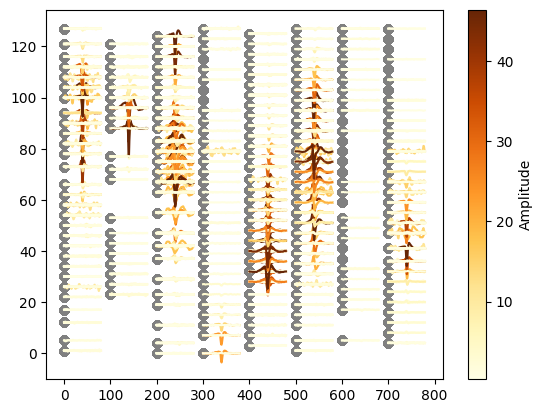

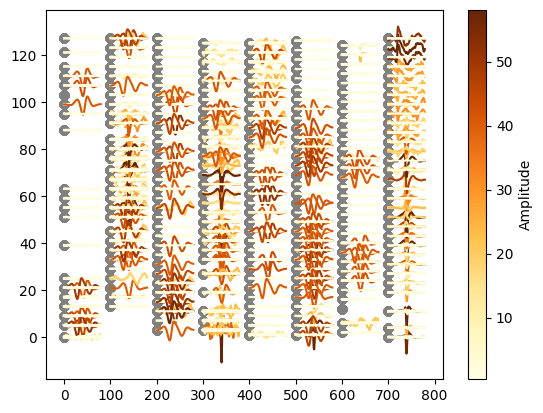

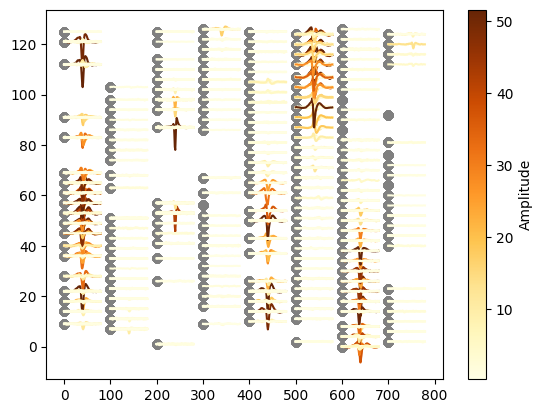

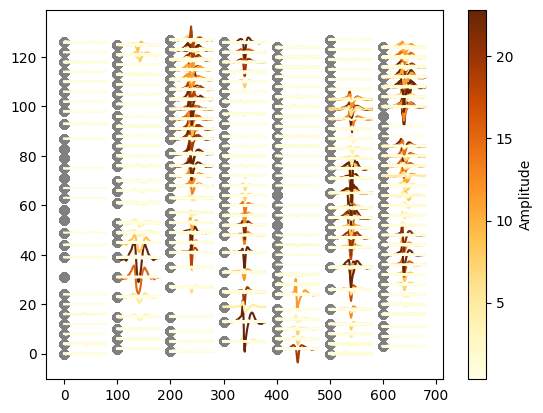

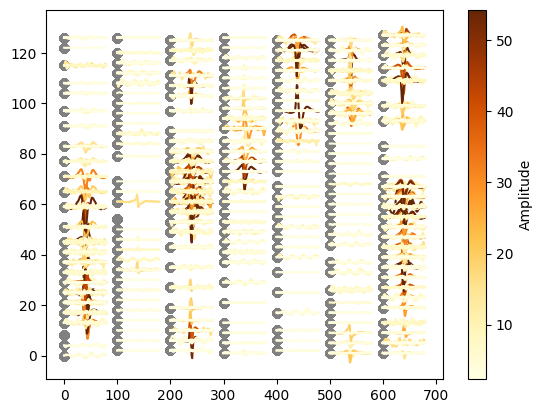

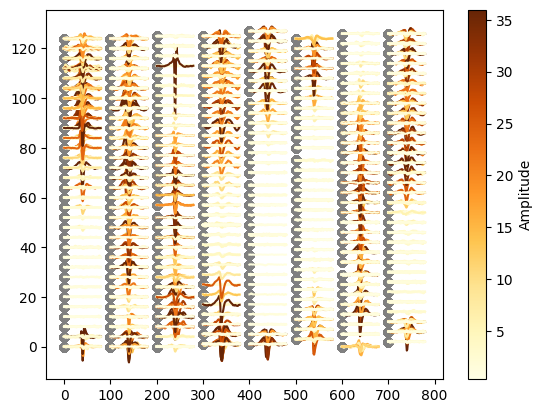

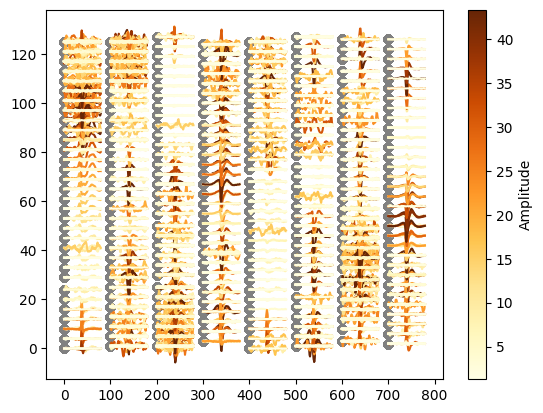

In [14]:
for i in range(len(channel_waveforms_all)):
    visualize_channel_waveform(channel_waveforms_all[i], goodChannels_all[i], n_neurons=len(channel_waveforms_all[i]), percentile=90, channel_samples=4)

### 2. Amplitude Based Features

In [15]:
channel_waveforms_all[0].shape

(184, 917, 80)

In [16]:
amplitudes_all = []

for i in range(len(sessions)):
    channel_waveforms = channel_waveforms_all[i]
    amplitude = channel_waveforms.max(axis=2) - channel_waveforms.min(axis=2)
    amplitudes_all.append(amplitude)

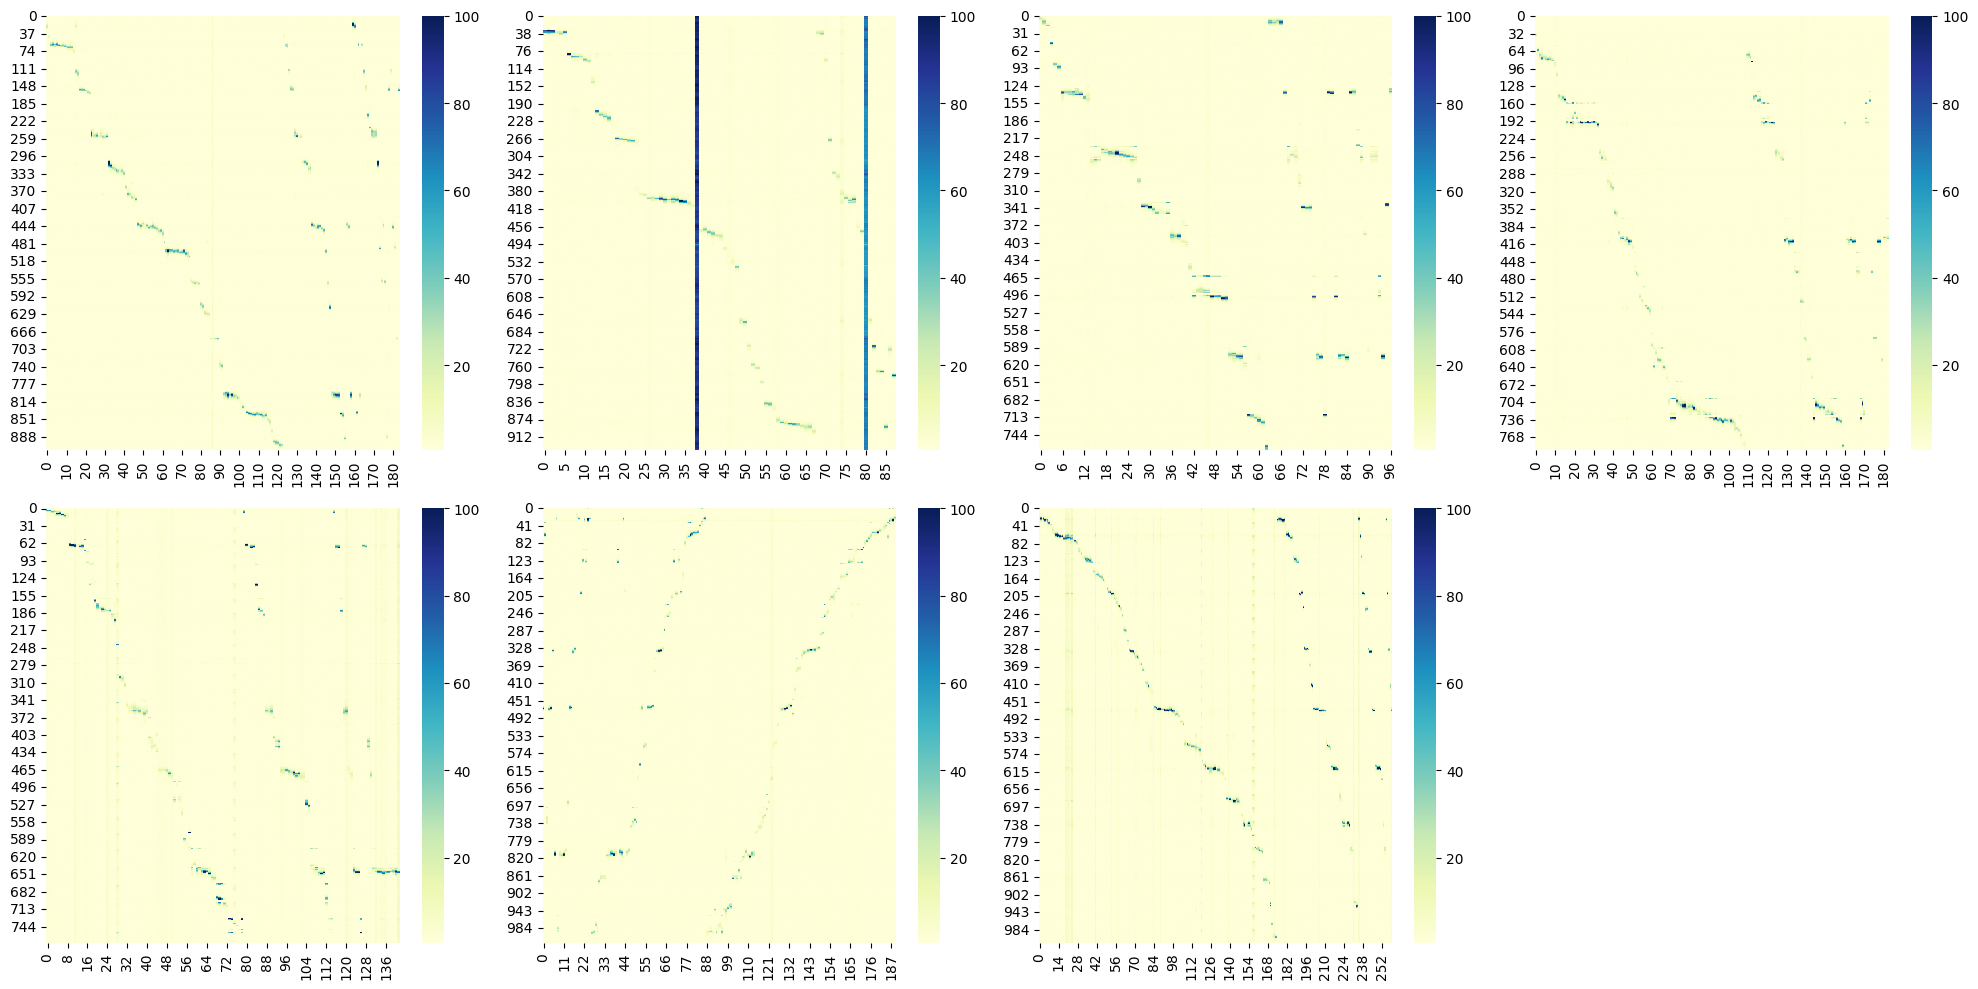

In [17]:
# plot the peak to peak amplitude for each unit received by each channel
plt.figure(figsize=(20, 10))
for i in range(len(session_names)):
    plt.subplot(2, 4, i+1)
    sns.heatmap(amplitudes_all[i].T, fmt="d", cmap="YlGnBu", vmax=100)
plt.tight_layout()

In [18]:
def plot_waveform_features(waveform_features, depth, class_labels_all, xlim=(0, 300), ylim=(0, 128), xtitle='Amplitude'):
    color_names = ['red', 'orange', 'green', 'blue', 'magenta']

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    
    for i, ax in enumerate(axes.flatten()):
        if i < len(session_names):
            xs = waveform_features[i]
            ys = depth[i]
            c = [color_names[j] for j in class_labels_all[i]]
            
            scatter = ax.scatter(xs, ys, c=c, alpha=0.7, edgecolors='k', s=50)
            ax.set_xlabel(xtitle, fontsize=12)
            ax.set_ylabel("Depth", fontsize=12)
            ax.set_ylim(ylim)
            ax.set_xlim(xlim)
            ax.set_title(session_names[i], fontsize=14)
            ax.grid(True, linestyle='--', alpha=0.6)
        else:
            ax.axis('off')
        
    plt.show()

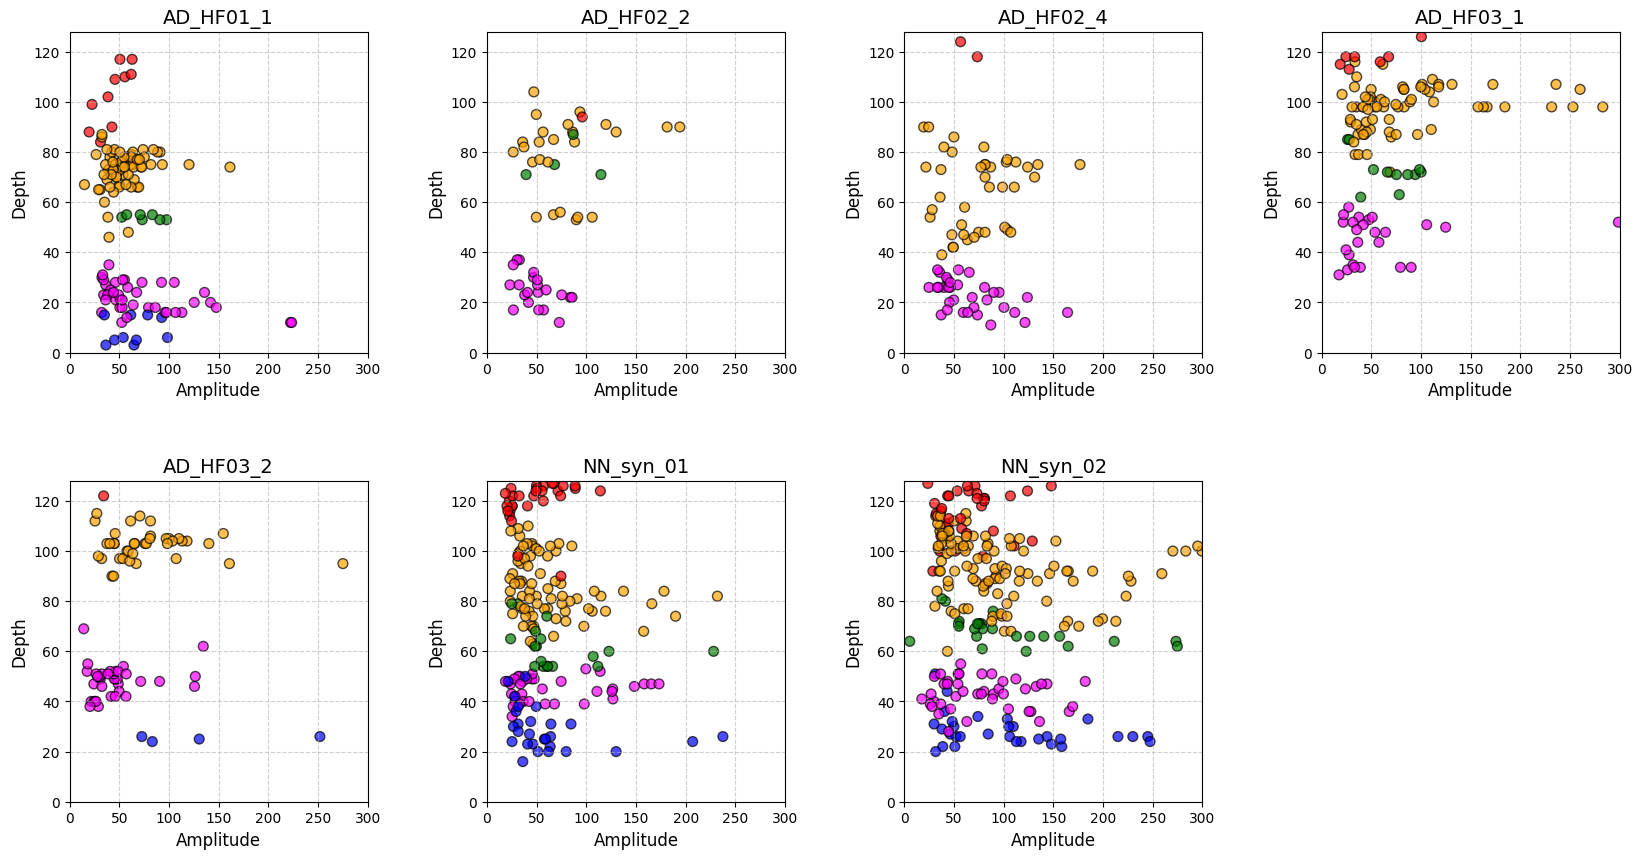

In [19]:
amplitude_all, depth_all = [], []

for i in range(len(sessions)):
    amplitude = np.max(waveforms_all[i], axis=1) - np.min(waveforms_all[i], axis=1)
    maxWaveformCh = maxWaveformCh_all[i]
    class_label_selected = class_labels_all[i][maxWaveformCh]
    
    depths = np.mod(maxWaveformCh_all[i], 128)
    amplitude_all.append(amplitude)
    depth_all.append(depths[class_label_selected != 5])

plot_waveform_features(amplitude_all, depth_all, class_labels_selected_all, xlim=(0, 300), ylim=(0, 128))

### 3. Waveform Based Features

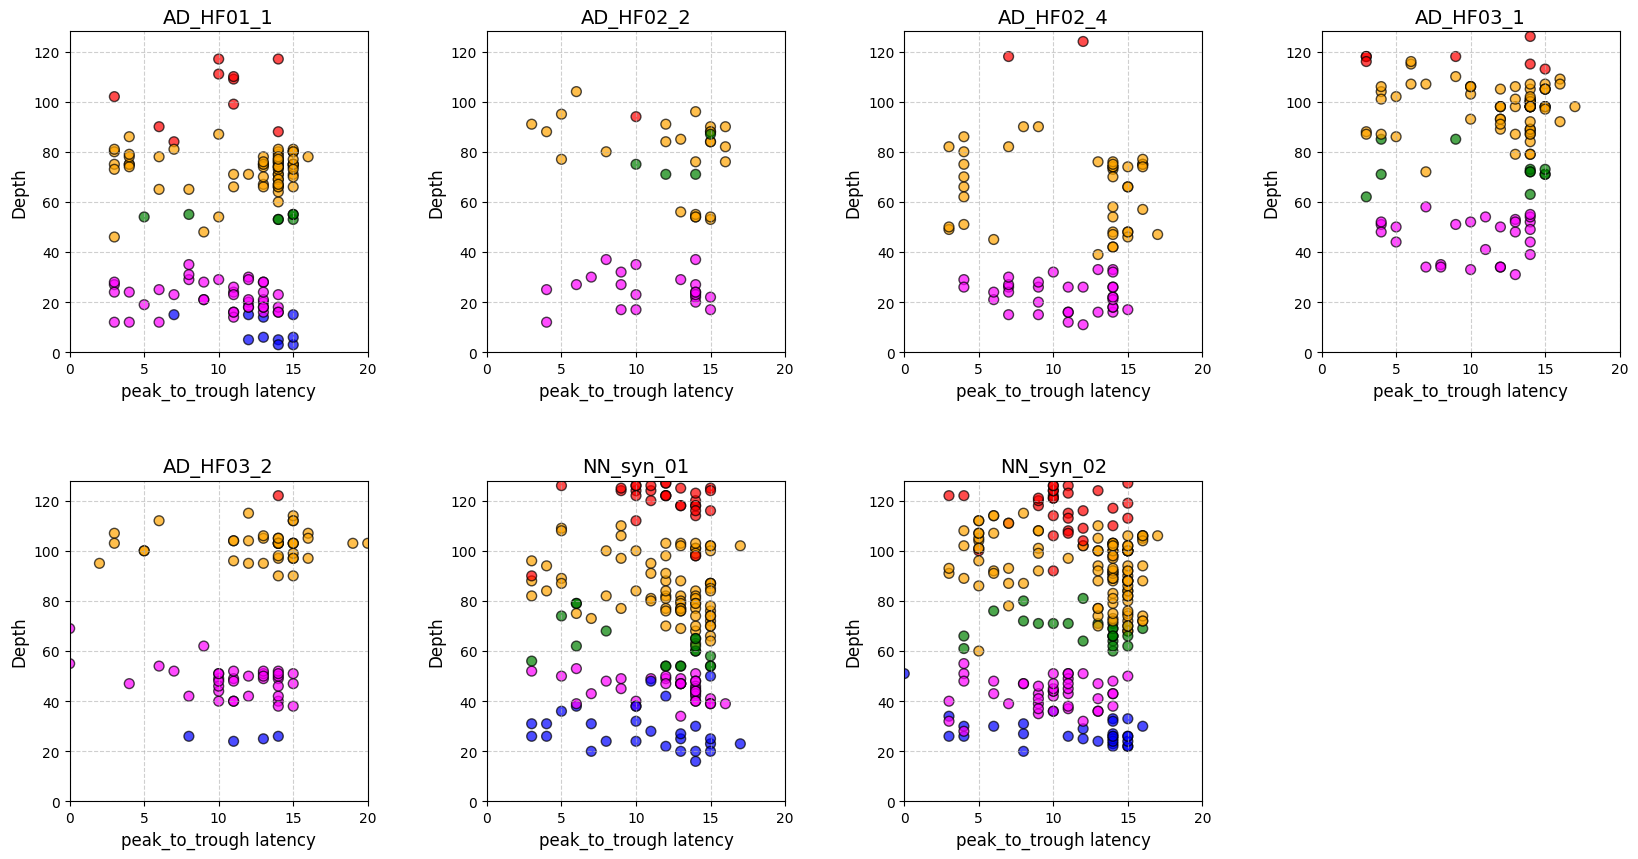

In [20]:
# compute peak to trough latency
p2t_latency_all = []

for i in range(len(sessions)):
    trough_index = np.argmin(waveforms_all[i], axis=1)
    peak_index = np.zeros(waveforms_all[i].shape[0], dtype=int)

    for j in range(waveforms_all[i].shape[0]):
        peak_index[j] = np.argmax(waveforms_all[i][j, trough_index[j]:]) + trough_index[j]
    
    p2t_latency = peak_index - trough_index
    p2t_latency_all.append(p2t_latency)

plot_waveform_features(p2t_latency_all, depth_all, class_labels_selected_all, xlim=(0, 20), ylim=(0,128), xtitle='peak_to_trough latency')

In [21]:
### other options: a-b ratio, peak-to-peak time, 1st peak-trough, amplitude, end-slope, peak-trough ratio

### 4. Time based Features

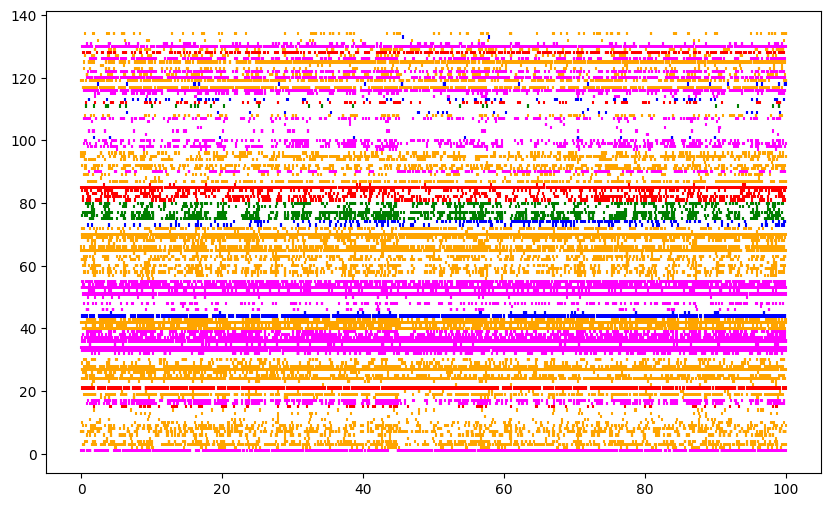

In [22]:
T = 100

filtered_spike_times = [[spike for spike in neuron_spikes if spike < T] for neuron_spikes in spike_times_all[0]]
colors = [color_names[j] for j in class_labels_selected_all[0]]

plt.figure(figsize=(10, 6))
for neuron_idx, spikes in enumerate(filtered_spike_times):
    plt.vlines(spikes, neuron_idx + 0.5, neuron_idx + 1.5, colors=colors[neuron_idx])

In [23]:
sessions=['AD_HF01_Session1h', 'AD_HF02_230706_Session2', 'AD_HF02_230722_Session4', 'AD_HF03_230725_Session1', 'AD_HF03_230726_Session2', 'NN_syn_20230601', 'NN_syn_20230607']
firing_rates_all = []
T = 1000

for i, session in enumerate(sessions):
    filtered_spike_times = [[spike for spike in neuron_spikes if spike < T] for neuron_spikes in spike_times_all[i]]
    # average_firing_rates = [np.mean(1/np.diff(t)) for t in filtered_spike_times]
    average_firing_rates = [len(t)/T for t in filtered_spike_times]
    firing_rates_all.append(average_firing_rates)

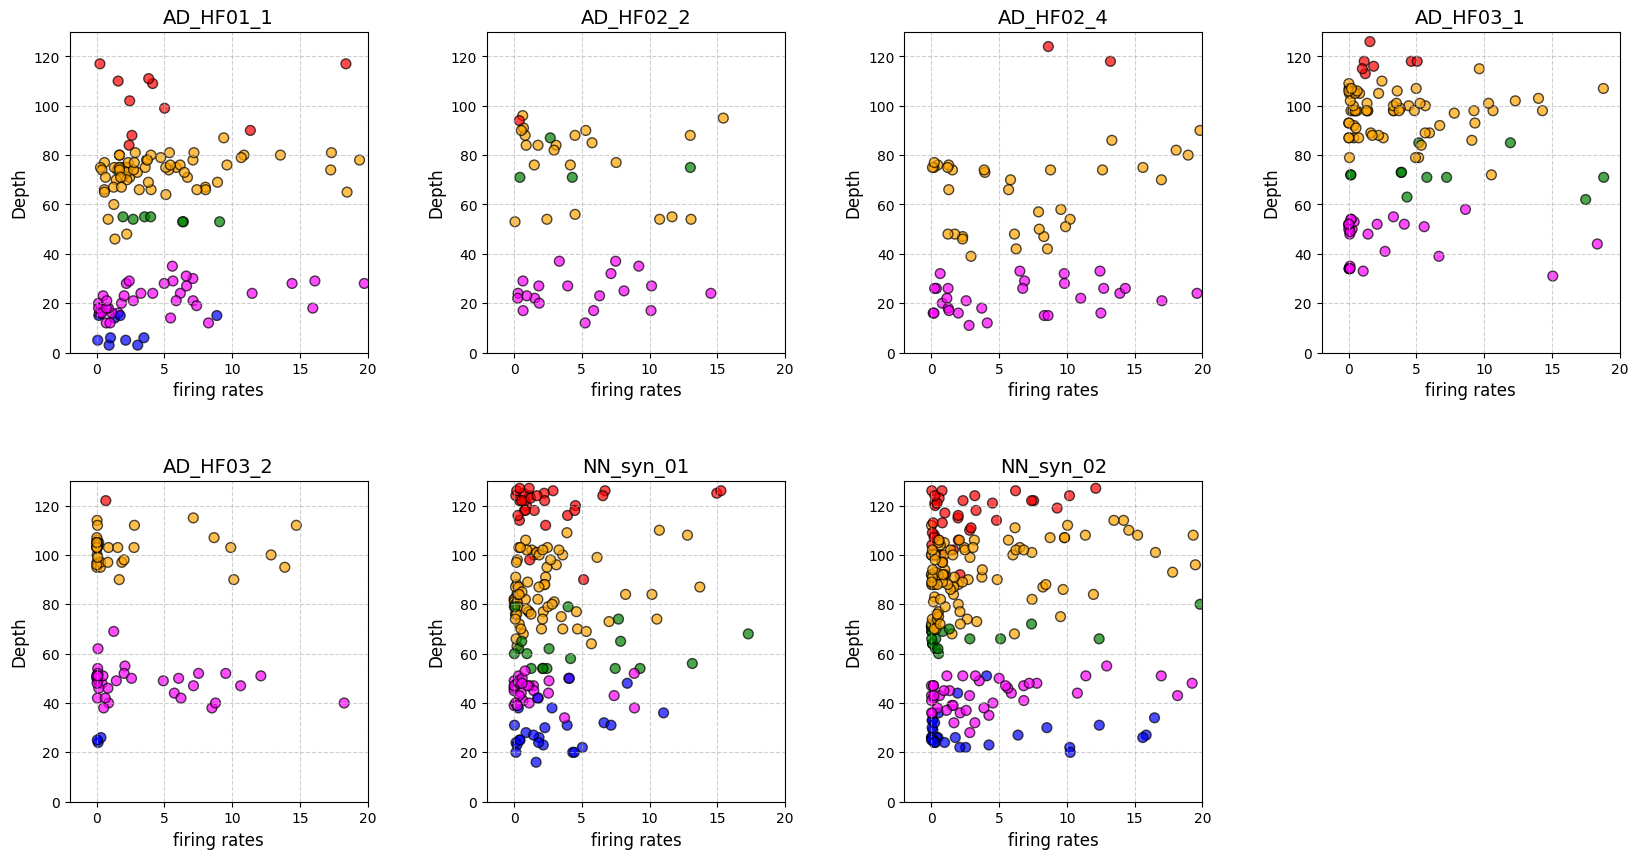

In [24]:
# pyramidal neuron typically has firing rate < 5hz, whereas interneuons firing rate is often >5 Hz
plot_waveform_features(firing_rates_all, depth_all, class_labels_selected_all, xlim=(-2, 20), ylim=(0,130), xtitle='firing rates')

In [25]:
import pynapple as nap

epoch = nap.IntervalSet(start=0, end=1000, time_units="s")
filtered_spike_times = [[spike for spike in neuron_spikes if spike < T] for neuron_spikes in spike_times_all[0]]

ts_group = nap.TsGroup(
    {idx: nap.Ts(t=spike_train, time_units="s") for idx, spike_train in enumerate(filtered_spike_times)},
   time_support=epoch
)

In [26]:
# relative firing rate at each time lag (-0.9 to 0.9) of spike, normalized to the average firing rate
autocorrs = nap.compute_autocorrelogram(
    group=ts_group, binsize=100, windowsize=1000, time_units="ms", ep=epoch  # ms
)
print(autocorrs)

           0         1         2         3         4         5         6    \
-0.9  1.109249  1.630920  1.036372  1.229811  1.020408  0.952109  1.116543   
-0.8  1.134512  1.684058  1.010856  1.249106  0.765306  0.845766  1.221045   
-0.7  1.145543  1.767852  1.077603  1.103885  0.733418  1.018028  1.154818   
-0.6  1.149554  1.600264  1.042596  1.177003  0.829082  1.023004  1.150034   
-0.5  1.161395  1.941571  1.061577  1.282618  1.594388  1.256833  1.183651   
-0.4  1.193716  1.904784  1.050686  1.217624  1.243622  1.042904  1.211225   
-0.3  1.195799  1.890477  1.100474  1.489787  0.956633  1.215167  1.258692   
-0.2  1.220560  2.176604  1.132525  1.852333  0.892857  1.478225  1.501062   
-0.1  1.452554  2.207260  1.342414  2.345882  3.985969  2.567148  2.604007   
 0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 0.1  1.452515  2.209304  1.342103  2.348928  3.985969  2.567148  2.604259   
 0.2  1.220290  2.174560  1.132837  1.850301  0.892857  1.478225

In [27]:
autocorrelograms = []
T = 10000

for i in range(len(sessions)):
    epoch = nap.IntervalSet(start=0, end=T, time_units="s")
    filtered_spike_times = [[spike for spike in neuron_spikes if spike < T] for neuron_spikes in spike_times_all[i]]
    
    ts_group = nap.TsGroup(
        {idx: nap.Ts(t=spike_train, time_units="s") for idx, spike_train in enumerate(filtered_spike_times)},
       time_support=epoch
    )

    autocorrs = nap.compute_autocorrelogram(
        group=ts_group, binsize=5, windowsize=T, time_units="ms", ep=epoch  # ms
    )

    autocorrs.fillna(0, inplace=True)
    autocorrelograms.append(autocorrs.to_numpy().T)

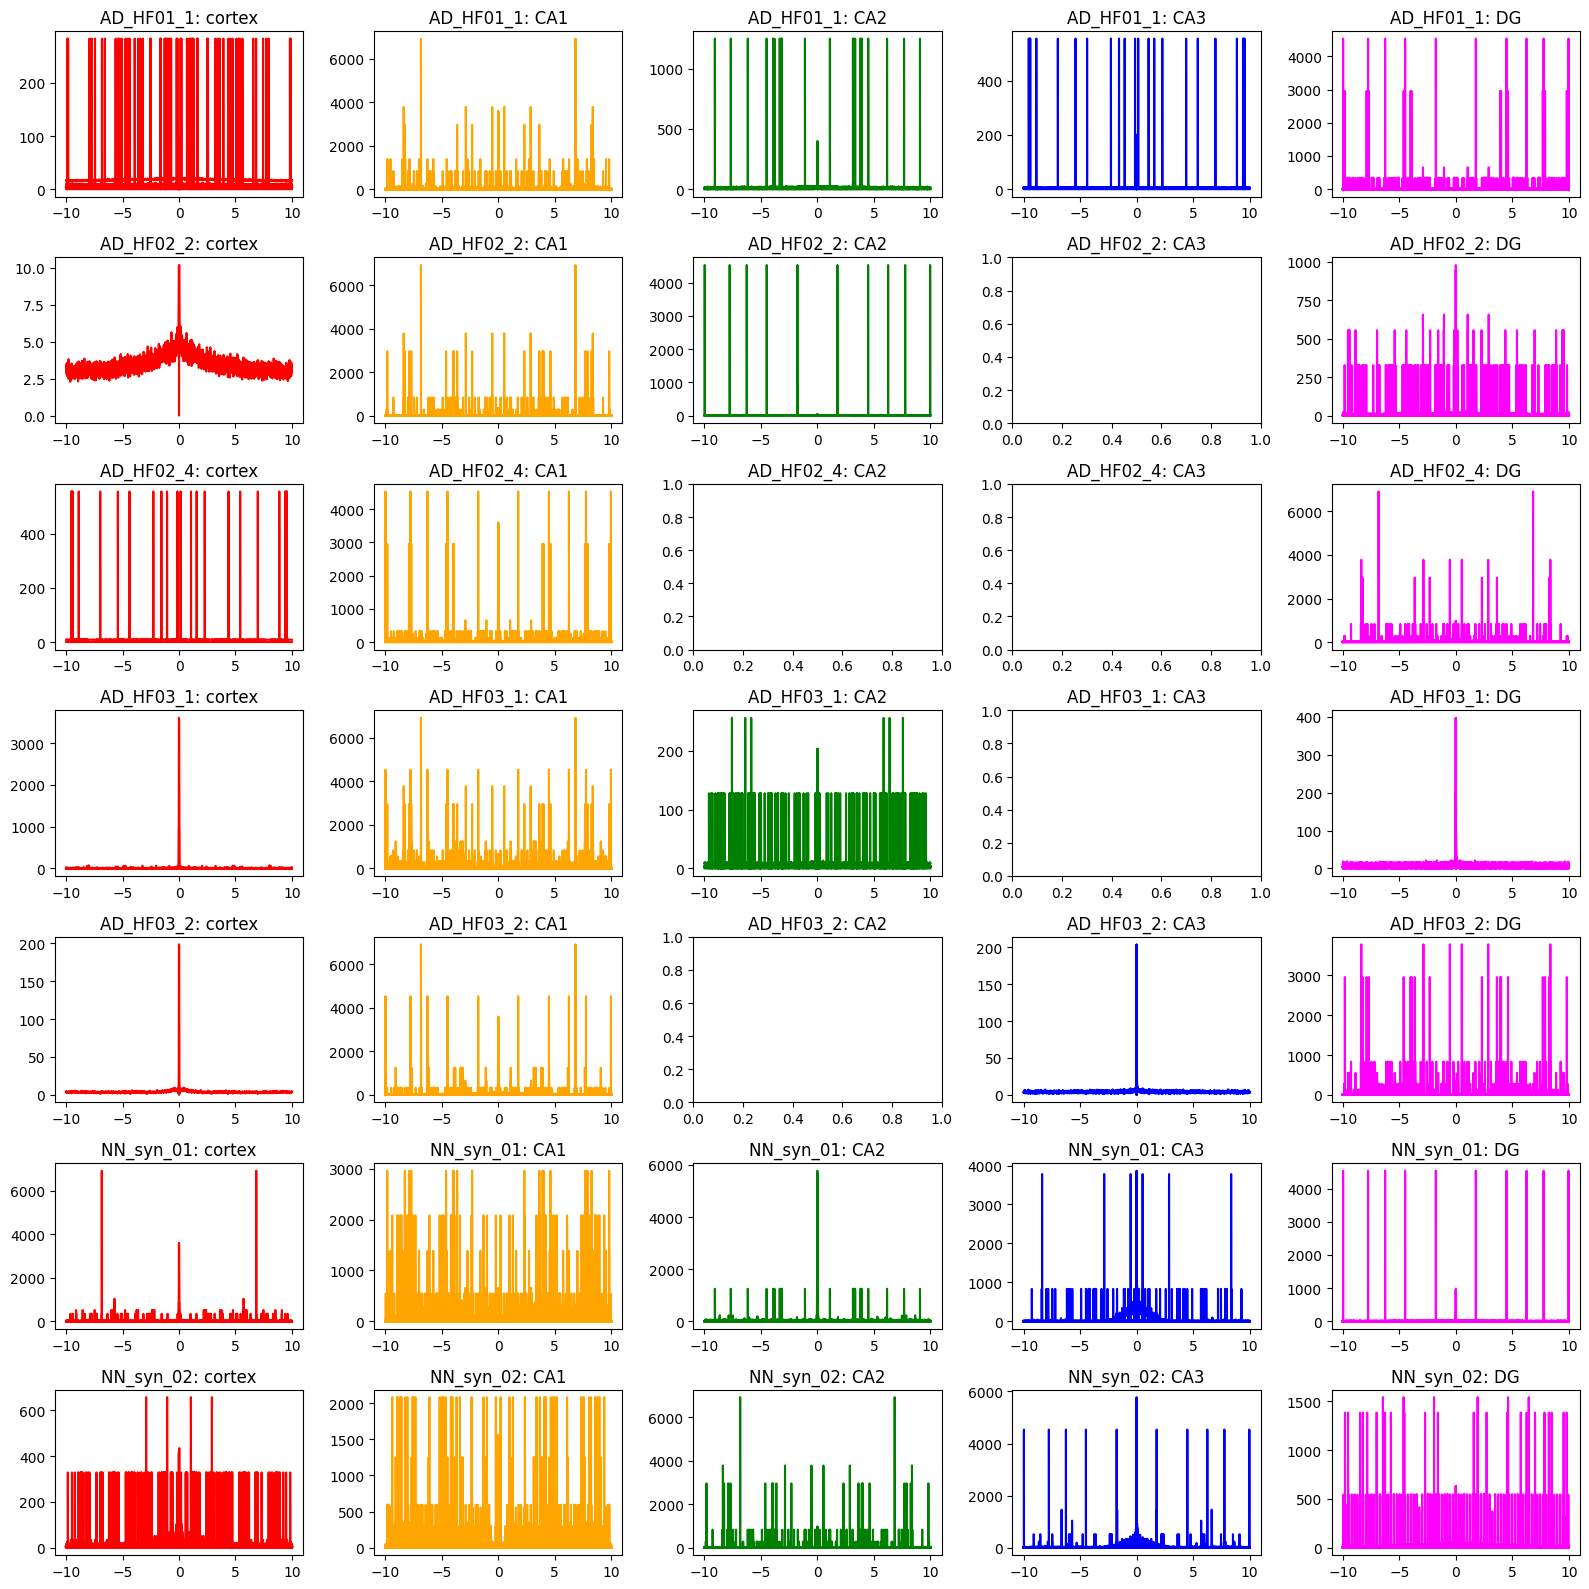

In [28]:
# normalize by the channels in std
fig, axes = plt.subplots(len(sessions), len(color_names)-1, figsize=(16, 16))
brain_regions = ['cortex', 'CA1', 'CA2', 'CA3', 'DG']

for s in range(len(session_names)):
    for color_idx, color in enumerate(color_names[:-1]):
        autocorr = autocorrelograms[s]
        colors = colors_all[s]
        lags = autocorrs.index
        
        for i, (autocorr, corr_color) in enumerate(zip(autocorr, colors)):
            if corr_color == color:
                axes[s][color_idx].plot(lags, autocorrs[i], c=color)
    
        axes[s][color_idx].set_title(f"{session_names[s]}: {brain_regions[color_idx]}")

plt.tight_layout()
plt.show()

In [29]:
np.array(p2t_latency_all[1]).shape, amplitudes_all[0].shape, np.array(firing_rates_all[1]).shape

((51,), (184, 917), (51,))

In [30]:
combined_features = []

for i in range(len(sessions)):
    combined_feature = np.vstack([amplitude_all[i], p2t_latency_all[i], firing_rates_all[i]]).T
    combined_features.append(combined_feature)

In [31]:
amplitude_all[0].shape

(134,)

In [32]:
index_train, index_test = train_test_split(np.arange(len(sessions)), test_size=0.2, random_state=42)

# X_train = np.vstack([autocorrelograms[i] for i in index_train])
# X_test = np.vstack([autocorrelograms[i] for i in index_test])
X_train = np.vstack([combined_features[i] for i in index_train])
X_test = np.vstack([combined_features[i] for i in index_test])

y_train = np.hstack([class_labels_selected_all[i] for i in index_train])
y_test = np.hstack([class_labels_selected_all[i] for i in index_test])

In [33]:
clf = LogisticRegression(C=1e-4)
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Train Accuracy: 0.48
Test Accuracy: 0.4918918918918919


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


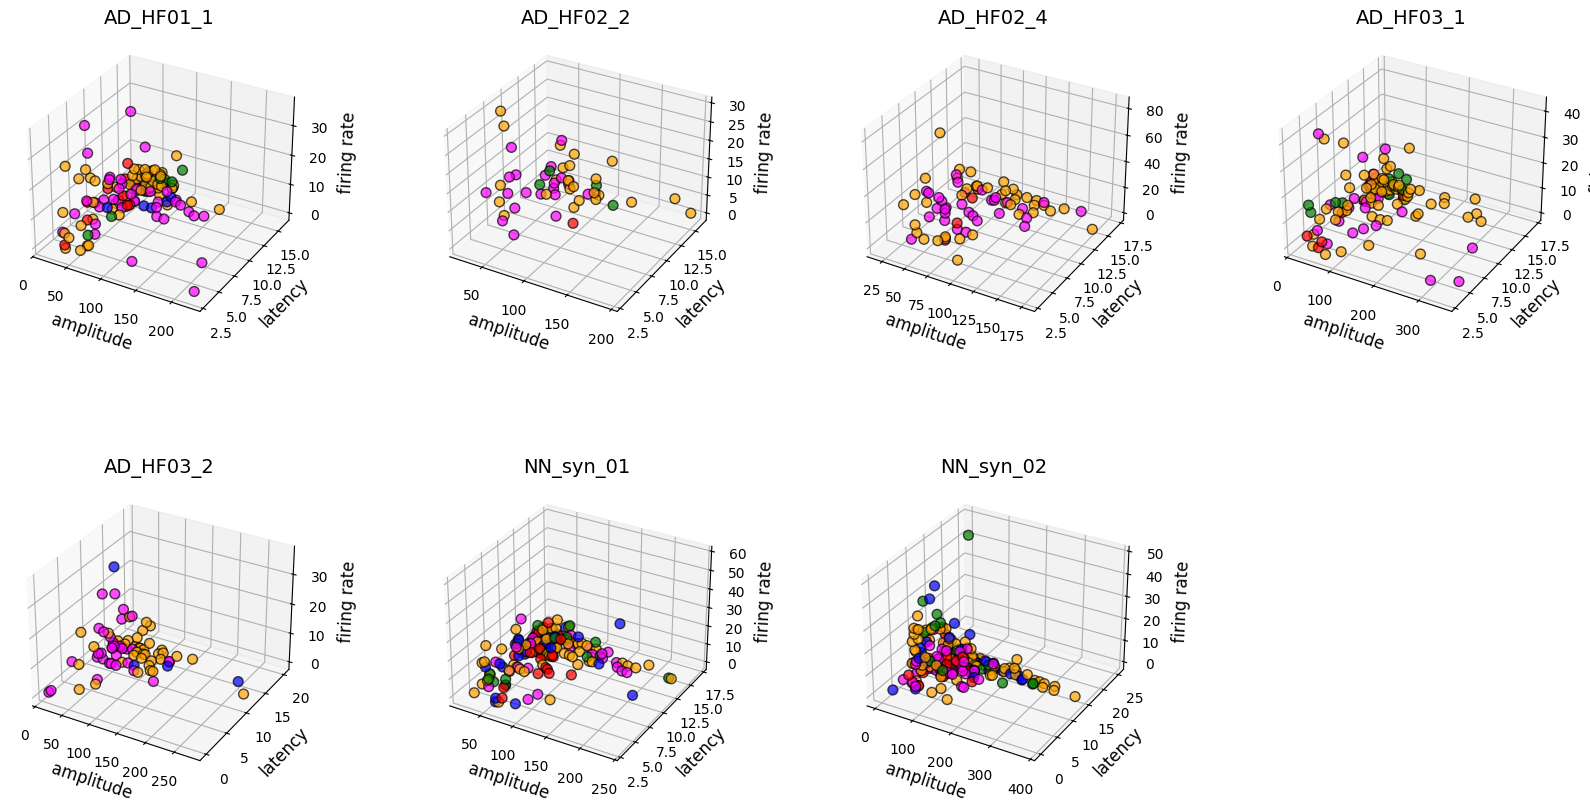

In [34]:
color_names = ['red', 'orange', 'green', 'blue', 'magenta']

fig, axes = plt.subplots(2, 4, figsize=(20, 10), subplot_kw={"projection": "3d"})
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i, ax in enumerate(axes.flatten()):
    if i < len(session_names):
        xs = amplitude_all[i]
        ys = p2t_latency_all[i]
        zs = firing_rates_all[i]
        c = [color_names[j] for j in class_labels_selected_all[i]]
        
        scatter = ax.scatter(xs, ys, zs, c=c, alpha=0.7, edgecolors='k', s=50)
        ax.set_xlabel("amplitude", fontsize=12)
        ax.set_ylabel("latency", fontsize=12)
        ax.set_zlabel("firing rate", fontsize=12)
        ax.set_title(session_names[i], fontsize=14)
        ax.grid(True, linestyle='--', alpha=0.6)
    else:
        ax.axis('off')
    
plt.show()